In [1]:
# Importing all the necessary libraries
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
import xgboost
from xgboost import plot_importance
from xgboost import XGBClassifier
import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import auc, roc_curve, classification_report
import math
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

#import sys
#!{sys.executable} -m pip install cufflinks
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
# import cufflinks and offline mode
import cufflinks as cf
cf.go_offline()

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from collections import Counter

from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping

C:\Users\yijia\anaconda3\envs\py3-TF2.0\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Goal

Employee turn-over is a very costly problem for companies. The cost of replacing an employee
if often larger than 100K USD, taking into account the time spent to interview and find a
replacement, placement fees, sign-on bonuses and the loss of productivity for several months.

It is only natural then that data science has started being applied to this area. Understanding
why and when employees are most likely to leave can lead to actions to improve employee
retention as well as planning new hiring in advance. This application of DS is sometimes called
people analytics or people data science (if you see a job title: people data scientist, this is your
job).

In this challenge, you have a data set with info about the employees and have to predict when
employees are going to quit by understanding the main drivers of employee churn

In [2]:
data = pd.read_csv('Employee_Rentation.csv', index_col=[0])
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
1,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
2,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
3,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
4,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
5,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24702 entries, 1 to 24702
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  24702 non-null  float64
 1   company_id   24702 non-null  int64  
 2   dept         24702 non-null  object 
 3   seniority    24702 non-null  int64  
 4   salary       24702 non-null  float64
 5   join_date    24702 non-null  object 
 6   quit_date    13510 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 1.5+ MB


In [4]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
employee_id,24702.0,501604.403530,288909.026101,36.0,250133.75,500793.0,753137.25,999969.0
company_id,24702.0,3.426969,2.700011,1.0,1.00,2.0,5.00,12.0
seniority,24702.0,14.127803,8.089520,1.0,7.00,14.0,21.00,99.0
salary,24702.0,138183.345478,76058.184573,17000.0,79000.00,123000.0,187000.00,408000.0


The goal is to predict employee retention and understand its main drivers.
Specifically, you should:

- Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000.

- You should create a table with 3 columns: day, employee_headcount, company_id. What are the main factors that drive employee churn? Do they make sense? Explain your findings.

- If you could add to this data set just one variable that could help explain employee churn, what would that be?

In [5]:
# change string to datetime
data['quit_date'] = pd.to_datetime(data['quit_date'])
data['join_date'] = pd.to_datetime(data['join_date'])

In [11]:
## change NaT in the join_date and quit_date column to None
data.replace(np.nan, None, inplace=True)
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
1,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
2,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
3,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
4,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
5,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


### 1. Create a table with 3 columns: day, employee_headcount, company_id

In [14]:
data.quit_date.max()

Timestamp('2015-12-09 00:00:00')

In [16]:
date_range = pd.date_range(start = '2011-01-24', end = '2015-12-13', freq = 'D')
all_company_id = sorted(data['company_id'].unique())

In [19]:
day = []
company_id = []
employee_hc = []
for d in date_range:
    for c in all_company_id:
        day.append(d)
        company_id.append(c)
        temp = data[(data['join_date']<=d) & ((data['quit_date']>d) | (data['quit_date'].isnull())) & (data['company_id']==c)]
        employee_hc.append(len(temp))

In [20]:
head_count_table = pd.DataFrame({'day': day, 'company_id': company_id, 'employee_headcount': employee_hc})
head_count_table.tail()

,day,company_id,employee_headcount
21415,2015-12-13,8,468
21416,2015-12-13,9,432
21417,2015-12-13,10,385
21418,2015-12-13,11,4
21419,2015-12-13,12,12


In [21]:
#=================================================================================
# we can get this table in another way "merge"
#=================================================================================
# 1. I get for each day/company, how many quit/got hired on that day
data_join = data.groupby(['join_date', 'company_id'])['employee_id'].count()
data_quit = data.groupby(['quit_date', 'company_id'])['employee_id'].count()

In [34]:
from itertools import product
data_headcount = pd.DataFrame(list(product(date_range, all_company_id)), columns = ['day', 'company_id'])
data_headcount = pd.merge(data_headcount, data_join, how = 'left', left_on = ['day', 'company_id'], right_on = ['join_date', 'company_id'])
data_headcount = pd.merge(data_headcount, data_quit, how = 'left', left_on = ['day', 'company_id'], right_on = ['quit_date', 'company_id'])
data_headcount.fillna(0, inplace=True)
head_count_col = data_headcount.groupby('company_id')['employee_id_x'].cumsum()-data_headcount.groupby('company_id')['employee_id_y'].cumsum()
data_headcount_table = data_headcount.drop(['employee_id_x','employee_id_y'],axis=1)
data_headcount_table['head_count'] = head_count_col

In [36]:
data_headcount_table.tail()

,day,company_id,head_count
21415,2015-12-13,8,468.0
21416,2015-12-13,9,432.0
21417,2015-12-13,10,385.0
21418,2015-12-13,11,4.0
21419,2015-12-13,12,12.0


### 2. Understand Employee retention

#### 1st. Let's check how many days they stayed. This should matter, because people usually get bored in the same place for too long

In [37]:
days = data.quit_date - data.join_date
employment_length = np.array(list(map(lambda x: x.days, days)))

In [38]:
data['employment_length'] = employment_length

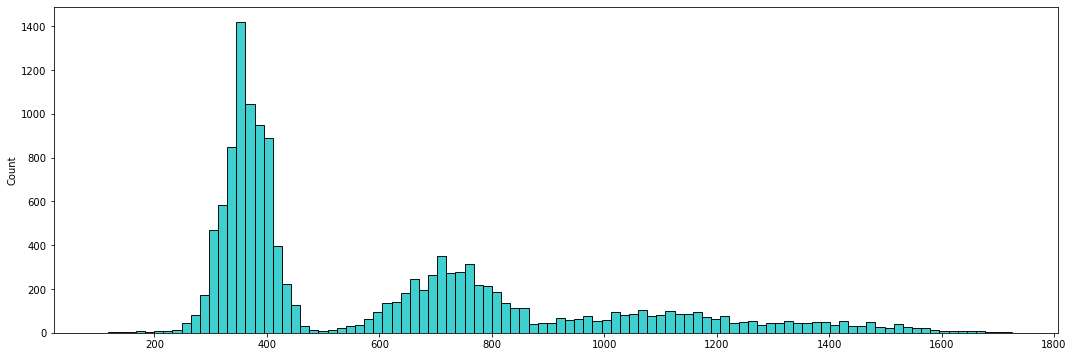

In [43]:
fig = plt.figure(figsize = (18, 6))
sns.histplot(employment_length, color = 'c', bins=100)
plt.show()

We can see from this histgram that, there are peaks around each employee year anniversary!!

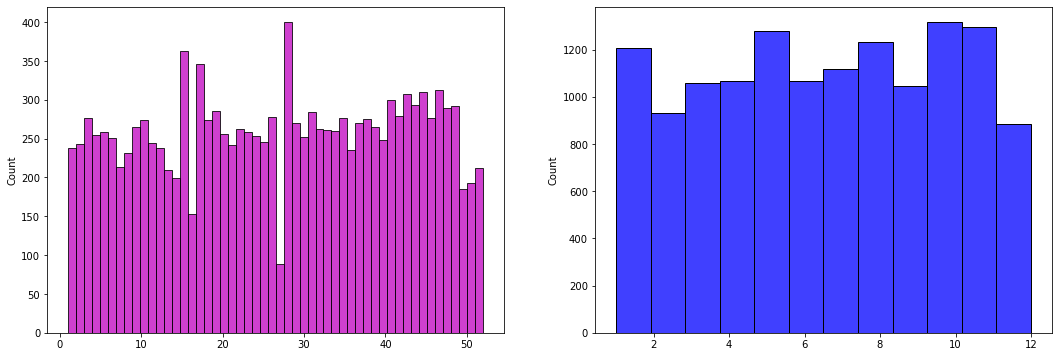

In [48]:
# plot week of the year
quit_date = data[~data['quit_date'].isnull()]
quit_week = np.array(list(map(lambda x: x.week, quit_date['quit_date'])))
quit_month = np.array(list(map(lambda x: x.month, quit_date['quit_date'])))

fig, ax = plt.subplots(nrows= 1, ncols = 2, figsize=(18, 6))
sns.histplot(quit_week, bins = len(np.unique(quit_week)), color = 'm', ax=ax[0])
sns.histplot(quit_month, bins = len(np.unique(quit_month)), color = 'b', ax = ax[1])
plt.show()

We can see there is no big difference among the week-of-year or month-of-year!

### 3. Find the characteristics of people who quit early

Looking at the histogram of employment_length, it looks like we could define early quitters as those people who quit within 1 yr or so.

So, let’s create two classes of users : quit within 13 months or not (if they haven’t been in the current company for at least 13 months, we remove them)

In [73]:
df = data[data['join_date']<(pd.to_datetime('2015-12-13')-pd.Timedelta(365+31, unit='d'))]

In [74]:
early_quitters = []
for i in range(df.shape[0]):
    if df['quit_date'].isnull().iloc[i]:
        early_quitters.append(0)
    elif (df['quit_date'].iloc[i] - df['join_date'].iloc[i]).days>(365+31):
        early_quitters.append(0)
    else:
        early_quitters.append(1)
df['early_quitters'] = early_quitters

In [75]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,employment_length,early_quitters
1,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0,0
2,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0,1
3,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaN,0
4,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0,1
5,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0,0


In [117]:
#=================================================
#Random Forest
#=================================================
#We are performing a numerical encoding to the categorical features, using the sklearn label encoder.
df['company_id'] = df['company_id'].astype(object)
from sklearn.preprocessing import LabelEncoder
for feature in df.select_dtypes(include='object'):
    lbl_enc = LabelEncoder()
    lbl_enc.fit(df[feature])
    df[feature] = lbl_enc.transform(df[feature])

In [118]:
feature = ['company_id', 'seniority','salary','dept']
Y = df['early_quitters']
model = RandomForestClassifier()
model.fit(df[feature], Y)
feature_importances = model.feature_importances_

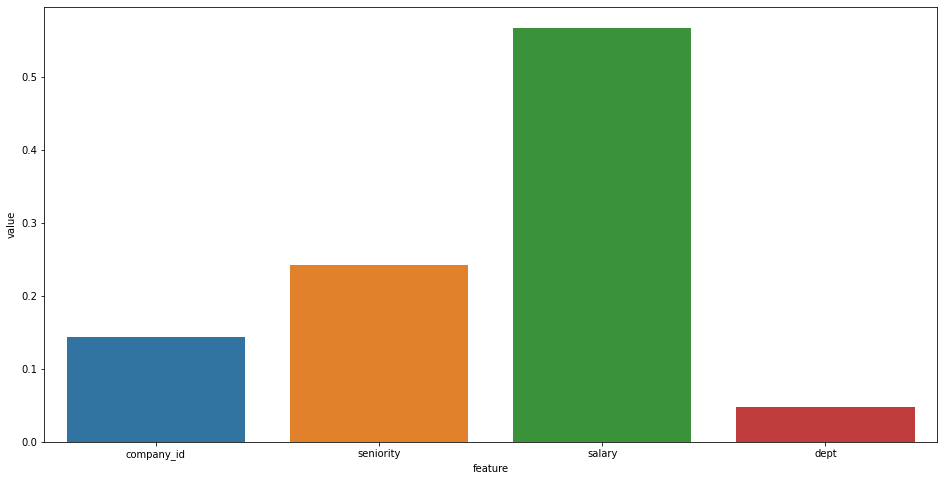

In [119]:
columns = ['feature', 'value']
importance = pd.DataFrame(feature_importances, index=feature).reset_index()
importance.columns = columns
fig = plt.figure(figsize = (16, 8))
sns.barplot(x='feature', y ='value', data=importance)
plt.show()

In [120]:
#=================================================
#Decision Tree 1
#=================================================
X = df[['seniority','salary']]
y = df['early_quitters']
dept = pd.get_dummies(df['dept'],drop_first=True,prefix='dept')
company = pd.get_dummies(df['company_id'],drop_first=True,prefix='company')
X = pd.concat([X, dept, company], axis=1)

In [151]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=30, random_state=20220718,class_weight="balanced")
clf = clf.fit(X=X , y=y)

In [152]:
# Feature importance
features = list(X.columns)
targets = ['Not quit', 'Quit']
importance = sorted(zip(features, clf.feature_importances_), key=lambda x:x[1], reverse=True)
for feature, val in importance:
    print('{0:10s} | {1:.5f}'.format(feature, val))

salary     | 0.97333
seniority  | 0.01667
company_8  | 0.01000
dept_1     | 0.00000
dept_2     | 0.00000
dept_3     | 0.00000
dept_4     | 0.00000
dept_5     | 0.00000
company_1  | 0.00000
company_2  | 0.00000
company_3  | 0.00000
company_4  | 0.00000
company_5  | 0.00000
company_6  | 0.00000
company_7  | 0.00000
company_9  | 0.00000
company_10 | 0.00000
company_11 | 0.00000


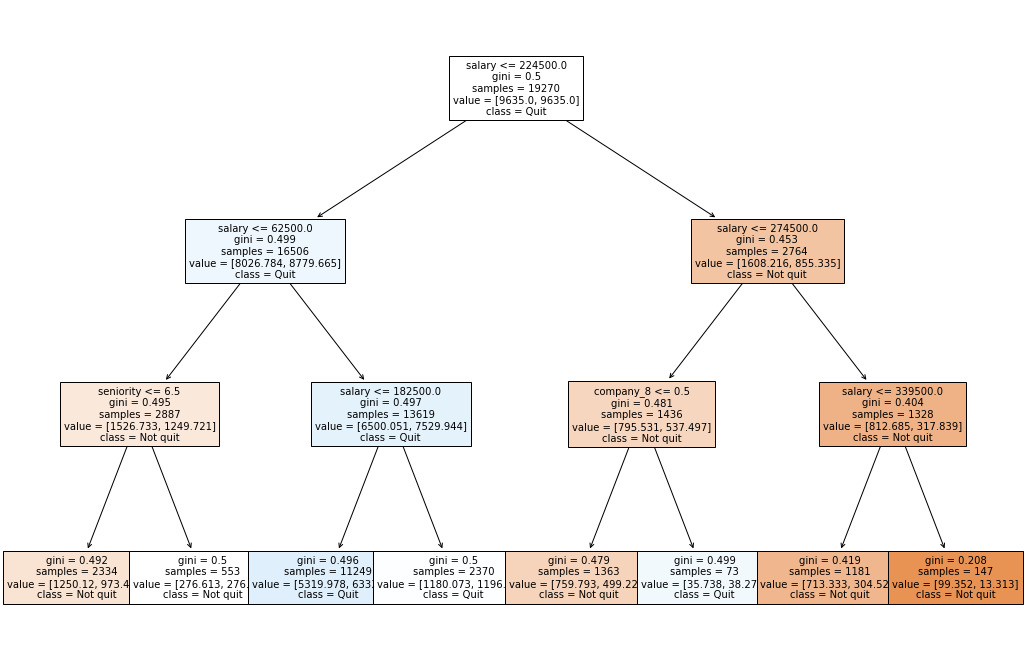

In [153]:
from sklearn.tree import plot_tree # tree diagram
plt.figure(figsize=(18,12))  # set plot size (denoted in inches)
tree.plot_tree(clf, fontsize=10, feature_names=features,  
                   class_names=targets,
                   filled=True)
plt.show()

Not very surprising! Salary is what matters the most. After all, it probably has within it information about the other variables too. That is, seniority, dept and company impact salary. So salary carries pretty much all the information available.

It is interesting though that, looking at the terminal nodes, the way the tree split is: If salary between 62500 and 224500, the employee has higher probability of being an early quitter, otherwise she doesn’t. That means that people who make a lot of money and very little are not likely to quit (“little money” by Silicon Valley standards).

#### By plotting the proportion of early quitter by salary percentile, this becomes quite clear:

In [222]:
df['Percentile'] = pd.cut(df.salary, bins=20, labels=False)+1


In [223]:
df_by_percentile = df[df['early_quitters']==1].groupby('Percentile')['early_quitters'].count()
total = df.groupby('Percentile')['early_quitters'].count()

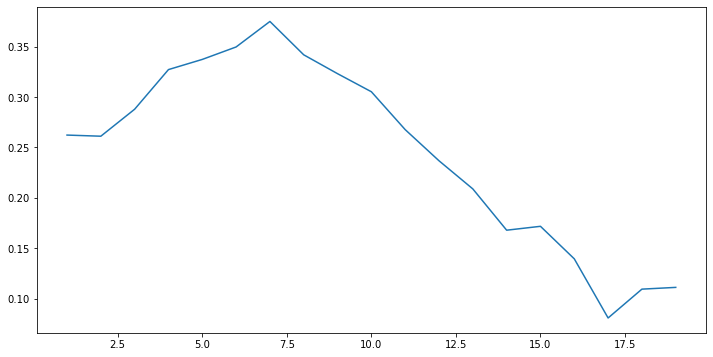

In [224]:
fig = plt.figure(figsize = (12,6))
plt.plot(df_by_percentile/total)
plt.show()

### Conclusion

1. Given how important is salary, I would definitely love to have as a variable the salary the employee who quit was offered in the next job. Otherwise, things like: promotions or raises received during the employee tenure would be interesting.

2. The major findings are that employees quit at year anniversaries, this makes sense. Even if you don’t like your current job, you often stay for 1 yr before quitting + you often get stocks after 1 yr so it makes sense to wait. Also, the beginning of the year is well known to be the best time to change job: companies are hiring more and you often want to stay until end of Dec to get the calendar year bonus.

3. Employees with low and high salaries are less likely to quit. Probably because employees with high salaries are happy there and employees with low salaries are not that marketable, so they have a hard time finding a new job.